In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from scripts.mechanics_domains_mapping import *

In [2]:
df = pd.read_csv('../data/cleaned_data_set_v4.csv', sep=',')
df

,Min Players,Max Players,Play Time,Min Age,Users Rated,Rating Average,BGG Rank,Complexity Average,Owned Users,Mechanics,Domains
0,1,4,120.000000,14,42055,8.792440,1,3.8604,68323.0,"Action Queue, Action Retrieval, Campaign / Bat...","Strategy Games, Thematic Games"
1,2,4,60.000000,13,41643,8.612780,2,2.8405,65294.0,"Action Points, Cooperative Game, Hand Manageme...","Strategy Games, Thematic Games"
2,2,4,120.000000,14,19217,8.663370,3,3.9129,28785.0,"Hand Management, Income, Loans, Market, Networ...",Strategy Games
3,1,5,120.000000,12,64864,8.432540,4,3.2406,87099.0,"Card Drafting, Drafting, End Game Bonuses, Han...",Strategy Games
4,3,6,431.858995,14,13468,8.453179,5,4.2219,16831.0,"Action Drafting, Area Majority / Influence, Ar...","Strategy Games, Thematic Games"
...,...,...,...,...,...,...,...,...,...,...,...
20338,2,2,30.000000,4,1340,2.278560,20340,1.0000,427.0,Unknown,Children's Games
20339,2,99,60.000000,5,2154,2.853310,20341,1.0455,1533.0,"Betting and Bluffing, Bingo, Pattern Recognition",Party Games
20340,2,4,30.000000,3,4006,3.177920,20342,1.0779,5788.0,Roll / Spin and Move,Children's Games
20341,2,6,30.000000,3,3783,2.855670,20343,1.0201,4400.0,"Dice Rolling, Grid Movement, Race, Roll / Spin...",Children's Games


### Null values
#### Since there are 23 null values in the column Owned Users, we can drop those rows.

In [3]:
print(df.isna().sum())
df.dropna(inplace=True)
print(df.isna().sum())

Min Players            0
Max Players            0
Play Time              0
Min Age                0
Users Rated            0
Rating Average         0
BGG Rank               0
Complexity Average     0
Owned Users           23
Mechanics              0
Domains                0
dtype: int64
Min Players           0
Max Players           0
Play Time             0
Min Age               0
Users Rated           0
Rating Average        0
BGG Rank              0
Complexity Average    0
Owned Users           0
Mechanics             0
Domains               0
dtype: int64


## Encoding Domains
#### Since we know that there are 9 unique domains, we can map each unique domain to a bit, and then represent the unique combos in a 9 bit format that is then translated to decimal

In [4]:
extract_unique_values(df, "Domains", "Domains_Unique.txt")
df = one_hot_encode(df,unique_values_file="Domains_Unique.txt",column_name="Domains")
df.head()

,Min Players,Max Players,Play Time,Min Age,Users Rated,Rating Average,BGG Rank,Complexity Average,Owned Users,Mechanics,Domains,Abstract Games,Children's Games,Customizable Games,Family Games,Party Games,Strategy Games,Thematic Games,Unknown,Wargames
0,1,4,120.000000,14,42055,8.792440,1,3.8604,68323.0,"Action Queue, Action Retrieval, Campaign / Bat...","Strategy Games, Thematic Games",0,0,0,0,0,1,1,0,0
1,2,4,60.000000,13,41643,8.612780,2,2.8405,65294.0,"Action Points, Cooperative Game, Hand Manageme...","Strategy Games, Thematic Games",0,0,0,0,0,1,1,0,0
2,2,4,120.000000,14,19217,8.663370,3,3.9129,28785.0,"Hand Management, Income, Loans, Market, Networ...",Strategy Games,0,0,0,0,0,1,0,0,0
3,1,5,120.000000,12,64864,8.432540,4,3.2406,87099.0,"Card Drafting, Drafting, End Game Bonuses, Han...",Strategy Games,0,0,0,0,0,1,0,0,0
4,3,6,431.858995,14,13468,8.453179,5,4.2219,16831.0,"Action Drafting, Area Majority / Influence, Ar...","Strategy Games, Thematic Games",0,0,0,0,0,1,1,0,0


## Encoding Mechanics
### Since mechanics has ~188 unique values. We can't directly binary encode the mechanics, so first we are going to cluster similar mechanics under a SuperMechanic

In [5]:
#Do not open
mechanic_to_superlabel = {
    "Hand Management": "Resource Management",
    "Income": "Resource Management",
    "Trading": "Resource Management",
    "Market": "Resource Management",
    "Auction/Bidding": "Resource Management",
    "Deck Bag and Pool Building": "Resource Management",
    "Deck Construction": "Resource Management",
    "Delayed Purchase": "Resource Management",
    "Loans": "Resource Management",
    "Investment": "Resource Management",
    "Contracts": "Resource Management",
    "Tile Placement": "Resource Management",
    "Worker Placement": "Resource Management",
    "Worker Placement with Dice Workers": "Resource Management",
    "Commodity Speculation": "Resource Management",
    "Static Capture": "Resource Management",
    "Increase Value of Unchosen Resources": "Resource Management",

    "Area Majority / Influence": "Conflict Resolution",
    "Area Movement": "Conflict Resolution",
    "Area-Impulse": "Conflict Resolution",
    "Combat": "Conflict Resolution",
    "Command Cards": "Conflict Resolution",
    "Dice Rolling": "Conflict Resolution",
    "Re-rolling and Locking": "Conflict Resolution",
    "Kill Steal": "Conflict Resolution",
    "Take That": "Conflict Resolution",
    "King of the Hill": "Conflict Resolution",
    "Role Playing": "Conflict Resolution",
    "Secret Unit Deployment": "Conflict Resolution",
    "Tug of War": "Conflict Resolution",
    "Zone of Control": "Conflict Resolution",
    "Ratio / Combat Results Table": "Conflict Resolution",
    "Predictive Bid": "Conflict Resolution",
    "Bidding": "Conflict Resolution",
    "Auction: Dutch": "Conflict Resolution",
    "Auction: English": "Conflict Resolution",

    "Cooperative Game": "Collaboration",
    "Semi-Cooperative Game": "Collaboration",
    "Team-Based Game": "Collaboration",
    "Negotiation": "Collaboration",
    "Alliances": "Collaboration",
    "Force Commitment": "Collaboration",
    "Roles with Asymmetric Information": "Collaboration",

    "Pattern Building": "Puzzle Solving",
    "Set Collection": "Puzzle Solving",
    "Pattern Recognition": "Puzzle Solving",
    "Tile Placement": "Puzzle Solving",
    "Puzzle Solving": "Puzzle Solving",
    "Mancala": "Puzzle Solving",
    "Grid Coverage": "Puzzle Solving",
    "Hexagon Grid": "Puzzle Solving",
    "Enclosure": "Puzzle Solving",
    "Path Building": "Puzzle Solving",
    "Measurement Movement": "Puzzle Solving",
    "Line Drawing": "Puzzle Solving",

    "Action Points": "Strategy and Planning",
    "Action Queue": "Strategy and Planning",
    "Programming": "Strategy and Planning",
    "Simultaneous Action Selection": "Strategy and Planning",
    "Deck Building": "Strategy and Planning",
    "Variable Phase Order": "Strategy and Planning",
    "Tech Trees / Tech Tracks": "Strategy and Planning",
    "Variable Player Powers": "Strategy and Planning",
    "Legacy Game": "Strategy and Planning",
    "Finale Ending": "Strategy and Planning",
    "Scenario / Mission / Campaign Game": "Strategy and Planning",

    "Map Exploration": "Exploration",
    "Campaign / Battle Card Driven": "Exploration",
    "Narrative Choice / Paragraph": "Exploration",
    "Storytelling": "Exploration",
    "Hidden Movement": "Exploration",
    "Map Reduction": "Exploration",
    "Map Addition": "Exploration",
    "Legacy Game": "Exploration",
    "Scenario / Mission / Campaign Game": "Exploration",

    "Bluffing": "Social Interaction",
    "Role Playing": "Social Interaction",
    "Hidden Roles": "Social Interaction",
    "Voting": "Social Interaction",
    "Singing": "Social Interaction",
    "Bribery": "Social Interaction",
    "Player Judge": "Social Interaction",
    "Hot Potato": "Social Interaction",
    "Traitor Game": "Social Interaction",

    "Dice Rolling": "Randomness and Luck",
    "Push Your Luck": "Randomness and Luck",
    "Random Production": "Randomness and Luck",
    "Drawing": "Randomness and Luck",
    "Die Icon Resolution": "Randomness and Luck",
    "Critical Hits and Failures": "Randomness and Luck",
    "Rock-Paper-Scissors": "Randomness and Luck",
    "Betting and Bluffing": "Randomness and Luck",

    "Unknown": "Miscellaneous / Other",
    "Advantage Token": "Miscellaneous / Other",
    "Bias": "Miscellaneous / Other",
    "Elapsed Real Time Ending": "Miscellaneous / Other",
    "Static Capture": "Miscellaneous / Other",
    "Single Loser Game": "Miscellaneous / Other",
    "Passed Action Token": "Miscellaneous / Other",
    "I Cut You Choose": "Miscellaneous / Other",
    "Action Timer": "Miscellaneous / Other"
}
mapping_file = "mechanic_to_superlabel.txt"
df = map_to_supermechanics(df,column_name="Mechanics",mapping_file=mapping_file)
df = one_hot_encode_mechanics(df,column_name="Mechanics_SuperMechanic")
df.head()

,Min Players,Max Players,Play Time,Min Age,Users Rated,Rating Average,BGG Rank,Complexity Average,Owned Users,Mechanics,...,Mechanics_SuperMechanic,Social Interaction,Strategy and Planning,Conflict Resolution,Exploration,Randomness and Luck,Resource Management,Puzzle Solving,Miscellaneous / Other,Collaboration
0,1,4,120.000000,14,42055,8.792440,1,3.8604,68323.0,"Action Queue, Action Retrieval, Campaign / Bat...",...,"Strategy and Planning, Exploration, Resource M...",0,1,0,1,0,1,1,0,1
1,2,4,60.000000,13,41643,8.612780,2,2.8405,65294.0,"Action Points, Cooperative Game, Hand Manageme...",...,"Strategy and Planning, Exploration, Resource M...",0,1,0,1,0,1,1,0,1
2,2,4,120.000000,14,19217,8.663370,3,3.9129,28785.0,"Hand Management, Income, Loans, Market, Networ...",...,"Strategy and Planning, Resource Management, Un...",0,1,0,0,0,1,0,0,0
3,1,5,120.000000,12,64864,8.432540,4,3.2406,87099.0,"Card Drafting, Drafting, End Game Bonuses, Han...",...,"Strategy and Planning, Conflict Resolution, Re...",0,1,1,0,0,1,1,0,0
4,3,6,431.858995,14,13468,8.453179,5,4.2219,16831.0,"Action Drafting, Area Majority / Influence, Ar...",...,"Social Interaction, Strategy and Planning, Con...",1,1,1,0,1,1,1,0,0


## Dropping Columns
### Let's remove the domains, mechanics and SuperMechanics columns, since we don't need them.
### Also drop BGG_Rank since we don't gain something from that column

In [6]:
df.drop(columns=['Domains', 'Mechanics', 'Mechanics_SuperMechanic','BGG Rank'], inplace=True)
df.head()

,Min Players,Max Players,Play Time,Min Age,Users Rated,Rating Average,Complexity Average,Owned Users,Abstract Games,Children's Games,...,Wargames,Social Interaction,Strategy and Planning,Conflict Resolution,Exploration,Randomness and Luck,Resource Management,Puzzle Solving,Miscellaneous / Other,Collaboration
0,1,4,120.000000,14,42055,8.792440,3.8604,68323.0,0,0,...,0,0,1,0,1,0,1,1,0,1
1,2,4,60.000000,13,41643,8.612780,2.8405,65294.0,0,0,...,0,0,1,0,1,0,1,1,0,1
2,2,4,120.000000,14,19217,8.663370,3.9129,28785.0,0,0,...,0,0,1,0,0,0,1,0,0,0
3,1,5,120.000000,12,64864,8.432540,3.2406,87099.0,0,0,...,0,0,1,1,0,0,1,1,0,0
4,3,6,431.858995,14,13468,8.453179,4.2219,16831.0,0,0,...,0,1,1,1,0,1,1,1,0,0


## We can start feature selection now
### First let's make a correlation matrix

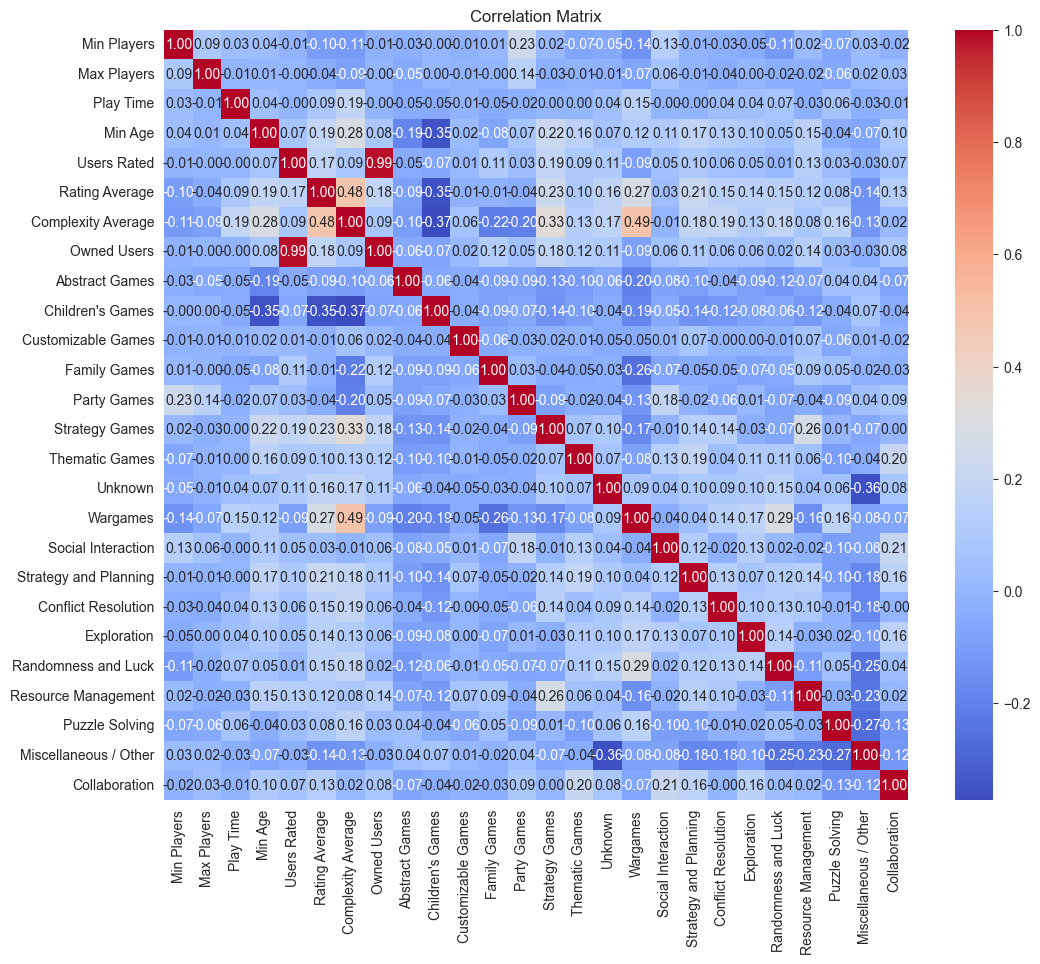

In [7]:
correlation_matrix = df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix')
plt.show()

In [8]:
correlation_matrix

,Min Players,Max Players,Play Time,Min Age,Users Rated,Rating Average,Complexity Average,Owned Users,Abstract Games,Children's Games,...,Wargames,Social Interaction,Strategy and Planning,Conflict Resolution,Exploration,Randomness and Luck,Resource Management,Puzzle Solving,Miscellaneous / Other,Collaboration
Min Players,1.000000,0.089602,0.032471,0.035525,-0.007688,-0.102664,-0.111490,-0.014511,-0.028913,-0.001075,...,-0.138923,0.134252,-0.012699,-0.026467,-0.047782,-0.112027,0.023186,-0.067217,0.029788,-0.018660
Max Players,0.089602,1.000000,-0.006010,0.008061,-0.001249,-0.039781,-0.089944,-0.000391,-0.053102,0.004211,...,-0.066769,0.064300,-0.008399,-0.044622,0.000856,-0.023496,-0.024774,-0.055359,0.019592,0.032304
Play Time,0.032471,-0.006010,1.000000,0.041217,-0.004100,0.088691,0.185874,-0.002472,-0.045410,-0.045784,...,0.147380,-0.003321,-0.002024,0.037099,0.041336,0.072205,-0.028970,0.062700,-0.027113,-0.007796
Min Age,0.035525,0.008061,0.041217,1.000000,0.072253,0.188660,0.283852,0.081218,-0.185597,-0.349864,...,0.118071,0.110695,0.170466,0.128273,0.096778,0.051887,0.150529,-0.035560,-0.067563,0.099450
Users Rated,-0.007688,-0.001249,-0.004100,0.072253,1.000000,0.170871,0.085298,0.986028,-0.050096,-0.065175,...,-0.094346,0.048808,0.095472,0.056520,0.048152,0.012988,0.134465,0.031871,-0.026776,0.066359
Rating Average,-0.102664,-0.039781,0.088691,0.188660,0.170871,1.000000,0.480924,0.178234,-0.092783,-0.351247,...,0.273257,0.032164,0.207703,0.150291,0.143457,0.149883,0.122381,0.082652,-0.139331,0.126913
Complexity Average,-0.111490,-0.089944,0.185874,0.283852,0.085298,0.480924,1.000000,0.086904,-0.102474,-0.371722,...,0.491666,-0.005203,0.183875,0.193971,0.126149,0.182922,0.078855,0.160515,-0.128860,0.016921
Owned Users,-0.014511,-0.000391,-0.002472,0.081218,0.986028,0.178234,0.086904,1.000000,-0.060119,-0.071821,...,-0.091351,0.055558,0.105424,0.059905,0.062027,0.022133,0.135792,0.029693,-0.031844,0.084595
Abstract Games,-0.028913,-0.053102,-0.045410,-0.185597,-0.050096,-0.092783,-0.102474,-0.060119,1.000000,-0.058694,...,-0.201309,-0.077441,-0.095501,-0.039918,-0.089721,-0.121260,-0.072186,0.044160,0.042326,-0.072558
Children's Games,-0.001075,0.004211,-0.045784,-0.349864,-0.065175,-0.351247,-0.371722,-0.071821,-0.058694,1.000000,...,-0.189312,-0.054176,-0.138551,-0.122743,-0.079096,-0.062470,-0.118266,-0.042118,0.069563,-0.041219


## Information Gain
#### Since we need to predict popularity and complexity of the Game.
#### We can assume that we need to see the information Gain for the Columns Complexity Average and Rating Average.

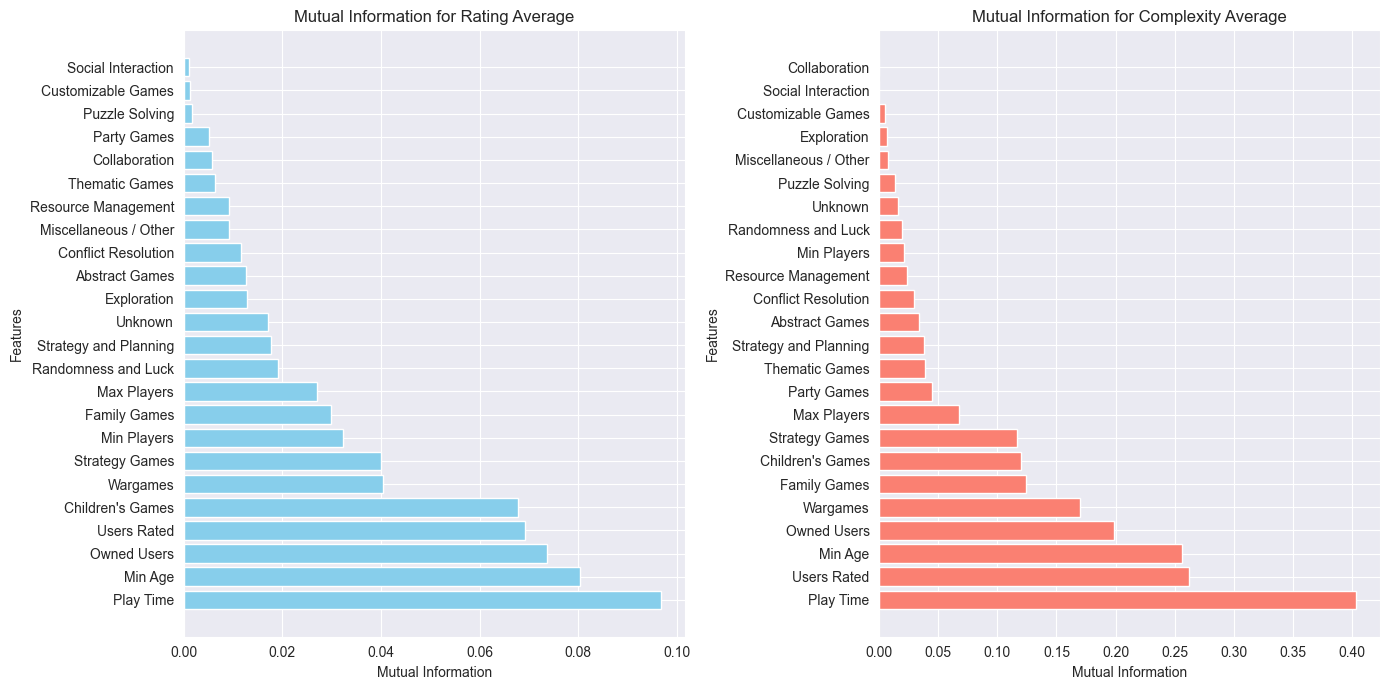

In [9]:
target_columns = ['Rating Average', 'Complexity Average']
feature_columns = [col for col in df.columns if col not in target_columns]

mi_scores = {}
for target in target_columns:
    mi = mutual_info_regression(df[feature_columns], df[target], random_state=42)
    mi_scores[target] = dict(zip(feature_columns, mi))

fig, axes = plt.subplots(1, 2, figsize=(14, 7))

rating_average_mi = mi_scores['Rating Average']
rating_average_mi_sorted = dict(sorted(rating_average_mi.items(), key=lambda item: item[1], reverse=True))

axes[0].barh(list(rating_average_mi_sorted.keys()), list(rating_average_mi_sorted.values()), color='skyblue')
axes[0].set_title('Mutual Information for Rating Average')
axes[0].set_xlabel('Mutual Information')
axes[0].set_ylabel('Features')

complexity_average_mi = mi_scores['Complexity Average']
complexity_average_mi_sorted = dict(sorted(complexity_average_mi.items(), key=lambda item: item[1], reverse=True))

axes[1].barh(list(complexity_average_mi_sorted.keys()), list(complexity_average_mi_sorted.values()), color='salmon')
axes[1].set_title('Mutual Information for Complexity Average')
axes[1].set_xlabel('Mutual Information')
axes[1].set_ylabel('Features')

plt.tight_layout()
plt.show()

In [13]:
complexity_average_mi_sorted

{'Play Time': np.float64(0.4037004356649314),
 'Users Rated': np.float64(0.26196202134697977),
 'Min Age': np.float64(0.25601921261007377),
 'Owned Users': np.float64(0.19889268793061898),
 'Wargames': np.float64(0.16999373253633498),
 'Family Games': np.float64(0.12414530025307169),
 "Children's Games": np.float64(0.12020030996462294),
 'Strategy Games': np.float64(0.11658776683467265),
 'Max Players': np.float64(0.06746980094739019),
 'Party Games': np.float64(0.0442288639262709),
 'Thematic Games': np.float64(0.03883524467029531),
 'Strategy and Planning': np.float64(0.0378367040660037),
 'Abstract Games': np.float64(0.03358149506573982),
 'Conflict Resolution': np.float64(0.029796752540073967),
 'Resource Management': np.float64(0.02328998618172573),
 'Min Players': np.float64(0.021296318398508873),
 'Randomness and Luck': np.float64(0.019529862283385047),
 'Unknown': np.float64(0.015591308111789104),
 'Puzzle Solving': np.float64(0.013313459311063536),
 'Miscellaneous / Other': np

## Recursive Feature Elimination

In [11]:
X = df[feature_columns]
y_rating = df['Rating Average']
y_complexity = df['Complexity Average']

rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

rfe_rating = RFE(rf_regressor)
rfe_rating.fit(X, y_rating)

rfe_complexity = RFE(rf_regressor)
rfe_complexity.fit(X, y_complexity)

selected_features_rating = [feature_columns[i] for i in range(len(rfe_rating.support_)) if rfe_rating.support_[i]]
selected_features_complexity = [feature_columns[i] for i in range(len(rfe_complexity.support_)) if
                                rfe_complexity.support_[i]]

selected_features_rating, selected_features_complexity

(['Min Players',
  'Max Players',
  'Play Time',
  'Min Age',
  'Users Rated',
  'Owned Users',
  "Children's Games",
  'Unknown',
  'Wargames',
  'Randomness and Luck',
  'Resource Management',
  'Puzzle Solving'],
 ['Min Players',
  'Max Players',
  'Play Time',
  'Min Age',
  'Users Rated',
  'Owned Users',
  "Children's Games",
  'Strategy Games',
  'Unknown',
  'Wargames',
  'Strategy and Planning',
  'Puzzle Solving'])

## **Conclusion**

### **1. Feature Correlation:**

- **Rating Average** and **Complexity Average** show varying degrees of correlation with other features:
    - **Rating Average**:
        - Moderate positive correlations with **Play Time** (0.0887) and **Min Age** (0.1887).
        - Weak correlations with features like **Users Rated** (0.1709), **Owned Users** (0.1782), and **Strategy Games** (0.2286).
    - **Complexity Average**:
        - Strong positive correlation with **Play Time** (0.1859) and **Min Age** (0.2839).
        - Moderate correlations with **Users Rated** (0.2601), **Owned Users** (0.2008), and **Wargames** (0.4917).

### **2. Mutual Information (MI) Scores:**

- **Rating Average**:
    - The highest MI score is with **Play Time** (0.0967), indicating that **Play Time** is an informative feature for predicting **Rating Average**.
    - Other important features for **Rating Average** include **Min Age** (0.0804), **Owned Users** (0.0736), and **Users Rated** (0.0692).
- **Complexity Average**:
    - The highest MI score for **Complexity Average** is with **Play Time** (0.4037), followed by **Min Age** (0.2560), **Users Rated** (0.2620), and **Owned Users** (0.1989).

### **3. Recursive Feature Elimination (RFE):**

- **RFE** selects the same set of features for both **Rating Average** and **Complexity Average**:
    - The selected features for both targets include:
        - **Min Players**, **Max Players**, **Play Time**, **Min Age**, **Users Rated**, **Owned Users**, **Strategy Games**, **Wargames**, and **Family Games**.
    - This suggests that **Play Time**, **Min Age**, and **Users Rated** are consistently important across both targets.

### **Conclusion:**

- **Key Features for Predicting Rating Average**:
    - **Play Time**: This feature has the highest MI score, making it the most informative feature for predicting the rating average.
    - Other important features include **Min Age**, **Owned Users**, and **Users Rated**.

- **Key Features for Predicting Complexity Average**:
    - **Play Time** and **Min Age** are crucial for predicting **Complexity Average** based on both MI and correlation.
    - **Users Rated** and **Owned Users** also play an important role, while features like **Wargames** and **Strategy Games** show moderate influence.

### **Next Steps:**

1. **Modeling**: Now that we have a refined set of features, experiment with different models (e.g., RandomForest, XGBoost, or others) for both **Rating Average** and **Complexity Average** to see which yields the best predictive performance.


In [16]:
df.to_csv("../data/training_data.csv",sep=",",index=False)